This Notebook aims to study the arguments developed by climate sceptics. This study is based on the database available at this address: https://www.figure-eight.com/data-for-everyone/.


**This Notebook needs approximately 2.5 minutes to run**

# 0. Import of constants and databases


In [0]:
#Import of packages
%matplotlib inline
import time 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pickle
import marshal
import io
import ast
import time 

#Tokenization 
import nltk
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TweetTokenizer
from functools import reduce
from operator import add
import collections
from collections import Counter

#Word2Vec
from gensim.models import Word2Vec
from multiprocessing import cpu_count

#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split

# Modèles de classifications
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
import xgboost as xgb
from xgboost import XGBClassifier

#BERT
import torch
!pip install pytorch_pretrained_bert
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

#Clustering 
from sklearn.cluster import KMeans

#nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
stopWords = set(stopwords.words('english'))

# Keras 
import keras
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence


#LDA
import gensim
import nltk
import time
from nltk.corpus import wordnet
import warnings
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

#SentiWordNet
from nltk.corpus import wordnet
from nltk.corpus import sentiwordnet as swn
from nltk.stem import PorterStemmer
nltk.download('sentiwordnet')

#Import of results and pre-run models (our repo github)

!pip install gitpython
import git


git.Git("sample_data").clone("git://github.com/salimYOU/Projet_NLP.git")
dic_representations=['tfidf','word2vec','fast2vec_cluster','fast2vec_mean', 'bert'] 
for name_representation in dic_representations:    
  df = pd.read_csv('sample_data/Projet_NLP/representations/{}.csv.gz'.format(name_representation), compression='gzip',index_col=0)
  df.to_csv('sample_data/Projet_NLP/representations/{}.csv'.format(name_representation))



     |████████████████████████████████| 133kB 2.8MB/s 
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
     |████████████████████████████████| 460kB 2.8MB/s 
     |████████████████████████████████| 71kB 8.8MB/s 


In [0]:
# Import of intial database

f = open('sample_data/Projet_NLP/tweet_global_warming.txt', 'r',newline='', encoding='ISO-8859-1')
content = f.read().split('\r')

content_new=[]
for x in content : 
    if len(x)>0:
        content_new.append(x)

content_new=content_new[1:len(content_new)]

##########################################################################################
##########################################################################################

# generation of the dataframe

col_tweet=[]
col_existence=[]
col_score=[]

#Split tweet/Score

for line in content_new:
    if len(line.split('[link]'))==2:
        (x,y)=line.split('[link]')
        col_tweet.append(x)
        col_existence.append(y)
    else : 
        if len(line.split(',Yes,'))==2:
            col_tweet.append(line.split(',Yes,')[0])
            col_existence.append(',Yes,'+line.split(',Yes,')[1])
        elif len(line.split(',No,'))==2:
            col_tweet.append(line.split(',No,')[0])
            col_existence.append(',No,'+line.split(',No,')[1])
        elif len(line.split(',Y,'))==2:
            col_tweet.append(line.split(',Y,')[0])
            col_existence.append(',Yes,'+line.split(',Y,')[1])
        elif len(line.split(',N/A,'))==2:
            col_tweet.append(line.split(',N/A,')[0])
            col_existence.append(',N/A,'+line.split(',N/A,')[1])
        elif len(line.split(',NA,'))==2:
            col_tweet.append(line.split(',NA,')[0])
            col_existence.append(',NA,'+line.split(',NA,')[1])
        elif len(line.split(',N,'))==2:
            col_tweet.append(line.split(',N,')[0])
            col_existence.append(',No,'+line.split(',N,')[1])

col_tweet.append('I truly  Fat ASS Gore should get the Scam Artist Award of the decade with his Global Warming and Energy Credits worth close to Billion')
col_existence.append(' ,NA')
col_tweet.append('Despite Climategate, LEFT investing heavily in global warming hysteria as new way 2 impose nat\'l & international controls on human freedom.')
col_existence.append(' ,NA')
        
# Split Existence/Note
col_existence_new=[]

for x in col_existence:
    if len(x.split(','))==3:
        col_existence_new.append(x.split(',')[1])
        col_score.append(x.split(',')[2])
    else:
        col_existence_new.append('NA')
        col_score.append('NA')
        
#Cleaning 'existence'
for avis in range(len(col_existence_new)):
    if col_existence_new[avis]=='NA' or col_existence_new[avis]=='N/A' or col_existence_new[avis]=='':
        col_existence_new[avis]=np.nan
        
#Cleaning 'score'
for score in range(len(col_score)):
    if 'NA' not in col_score[score]:
        col_score[score]=col_score[score].split('\t')[0]
        if len(col_score[score].split('"'))>1:
            col_score[score]=float(col_score[score].split('"')[0])
        else: 
            col_score[score]=float(col_score[score])
            
    else : 
        col_score[score]=np.nan

#Cleaning of the DataFrame
dic={'Tweet':col_tweet,'Existence':col_existence_new,'Score':col_score}
df=pd.DataFrame(dic)

df.drop_duplicates(['Tweet'], inplace=True)
df.reset_index(inplace=True,drop=True)

Some examples of tweets : 

In [0]:
# Examples of tweets

print('Examples of tweets from people who believe in climate change : ')
print(' ')
for k in range(5):
    print(df[df.Existence=='Yes'].reset_index().iloc[k]['Tweet'])
    print(' ')
    
print('#'*50)
print('#'*50)
print(' ')
print('Examples of tweets from people who not believe in climate change : ')
print(' ')
for k in range(5):
    print(df[df.Existence=='No'].reset_index().iloc[k]['Tweet'])
    print(' ')

Examples of tweets from people who believe in climate change : 
 
Global warming report urges governments to act|BRUSSELS, Belgium (AP) - The world faces increased hunger and .. 
 
Fighting poverty and global warming in Africa 
 
Carbon offsets: How a Vatican forest failed to reduce global warming 
 
URUGUAY: Tools Needed for Those Most Vulnerable to Climate Change 
 
RT @sejorg: RT @JaymiHeimbuch: Ocean Saltiness Shows Global Warming Is Intensifying Our Water Cycle 
 
##################################################
##################################################
 
Examples of tweets from people who not believe in climate change : 
 
Wait here's an idea: it's natural climate change, not human induced global warming. 
 
@New_federalists  i have it on good auth tht global warming also causes toe fungus.  We R all fortunate tht thr IS no global warming! #tcot
 
Illegal war and the myth of global warming|My main campaign platform for this election will be the illegal .. 
 
the scient

 A little description about the database : 

In [0]:
print('We have {} tweets.'.format(df.shape[0]))
print(' ')
print('We have {} missing data on the label from the tweet advisory (Yes, No) .'.format(str(df.isnull().sum()['Existence'])))
print(' ')
print('We have {} tweets from people who believe in climate change.'.format(str(df[df.Existence=='Yes'].shape[0])))
print('We have {} tweets from people who not believe in climate change.'.format(str(df[df.Existence=='No'].shape[0])))



We have 5539 tweets.
 
We have 1683 missing data on the label from the tweet advisory (Yes, No) .
 
We have 2821 tweets from people who believe in climate change.
We have 1035 tweets from people who not believe in climate change.


# I. Cleaning of the data and tweet representation (word-embedding) 

### I.a Tokenization of the tweets and cleaning of the tokens 

In [0]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].lower()
    tag_return = {"j": wordnet.ADJ,
                "n": wordnet.NOUN,
                "v": wordnet.VERB,
                "r": wordnet.ADV}
    return tag_return.get(tag, wordnet.NOUN)

# We take all sentences of all texts, and we concatenate them into a list
# We process them before

sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

def remove_hashtags(tokens):
    tokens= map(lambda x : x.replace('#',''),tokens) #map : go through all tokens
    return list(tokens)

def remove_url(tokens): 
    tokens= filter(lambda x: "http" not in x, tokens) 
    return list(tokens)

def remove_html(tokens):
    tokens= filter(lambda x: x[0]+x[-1]!='<>',tokens)
    return list(tokens)

def remove_www(tokens):
    tokens= filter(lambda x: "www" not in x, tokens) 
    return list(tokens)

def remove_contraction(sample):
    sample = sample.lower()
    sample = sample.replace('won\'t', ' will not')    
    sample = sample.replace('n\'t',' not')
    sample = sample.replace('\'ll',' will') 
    sample = sample.replace('it\'s','it is')    
    sample = sample.replace('he\'s','he is')    
    sample = sample.replace('she\'s','she is')    
    sample = sample.replace('\'re', ' are')
    sample = sample.replace('that\'s', 'that is')
    return sample


def RepresentsInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

def clean_ponctuation(text_tokens): # Cleaning of the ponctuation

    list_word_clean_ponctuation=[]
    for tweet in text_tokens:
        list_tweet=[]
        for word in tweet:
            if len(word)<2:
                if (word=='a') or (word=='i') or (word=='u'):
                    list_tweet.append(word)
                if RepresentsInt(word):
                    list_tweet.append(word)
            else :
                if (word!='..') & (word!='...') & (word!='rt'):
                    list_tweet.append(word)
        list_word_clean_ponctuation.append(list_tweet)
    
    return(list_word_clean_ponctuation)

def remove_arobase(text_tokens):
    
    list_new_tokens=[]
    for tweet in text_tokens:
        new_tweet=[]
        for word in tweet: 
            if '@' not in word:
                new_tweet.append(word)
        list_new_tokens.append(new_tweet)
    
    return(list_new_tokens)

###############################################################
###############################################################
###############################################################

def clean_text_first(corpus):
    
    tok=TweetTokenizer()
    tokens=[]
    for sample in corpus:
        sample = remove_contraction(sample)
        token=tok.tokenize(sample)
        token=remove_url(token)
        token=remove_html(token)
        token=remove_hashtags(token)
        token=remove_www(token)
        token2 = []
        for elt in token:
            if elt != '':
                if elt != "warming":
                    token2.append(lemmatizer.lemmatize(elt, get_wordnet_pos(elt)))
                else:
                    token2.append("warming")
        token=list(map(lambda x : x.lower(),token2)) #.lower() : convert upper on lower case
        tokens.append(token) #append token in all sentences 
    
    #Cleaning of ponctuation
    tokens=clean_ponctuation(tokens)
    
    #Cleaning of @ : mostly, they are proper names
    tokens=remove_arobase(tokens)
    
    return tokens

def clean_text_second(corpus,threshold=10, stopwords_out = False): #We add association of pairs words
    
    #Celaing of texts 
    tokens=clean_text_first(corpus)
    
    #Association of words 
    phrases=Phrases(tokens,threshold=threshold) 
    phraser=Phraser(phrases) 
    
    clean_tokens=[]
    for token in tokens: #We go through all sentences and associate words 
        new_tokens=phraser[token]
        if stopwords_out :
            new_tokens2 = []
            for elt in new_tokens:
                if elt not in stopWords:
                    new_tokens2.append(elt)
            clean_tokens.append(new_tokens2)
        else:
            clean_tokens.append(new_tokens)
    
    return(clean_tokens)

"""
# Save clean tokens 
clean_text=clean_text_second(df.Tweet)
data=pd.DataFrame([clean_text]).T
data.to_csv('sample_data/Projet_NLP/clean_text.csv')

df_yes=df[df.Existence=='Yes'].reset_index()
clean_text_yes=clean_text_second(df_yes.Tweet)
data=pd.DataFrame([clean_text_yes]).T
data.to_csv('sample_data/Projet_NLP/clean_text_yes.csv')

df_no=df[df.Existence=='No'].reset_index()
clean_text_no=clean_text_second(df_no.Tweet)
data=pd.DataFrame([clean_text_no]).T
data.to_csv('sample_data/Projet_NLP/clean_text_no.csv')
"""




# Fonction to import clean tokens 
def import_clean_text(option='all'):

    if option=='all':
        clean_new=[]
        clean_text=pd.read_csv('sample_data/Projet_NLP/clean_text.csv',index_col=0)
        for tweet in list(clean_text['0']):
            clean_new.append(ast.literal_eval(tweet))
        clean_text=clean_new

    if option=='yes':
        clean_new=[]
        clean_text=pd.read_csv('sample_data/Projet_NLP/clean_text_yes.csv',index_col=0)
        for tweet in list(clean_text['0']):
            clean_new.append(ast.literal_eval(tweet))
        clean_text=clean_new
        
    if option=='no':
        clean_new=[]
        clean_text=pd.read_csv('sample_data/Projet_NLP/clean_text_no.csv',index_col=0)
        for tweet in list(clean_text['0']):
            clean_new.append(ast.literal_eval(tweet))
        clean_text=clean_new
    
    return(clean_text)



Most frequent words after cleaning up tweets : 

In [0]:
#Most frequent words after cleaning up tweets : 

list_words=import_clean_text()

counter=collections.Counter(reduce(add, list_words))

#10 most common words  
number_word=10
print('{} words that appear the most are (in descending order) :'.format(number_word))
print(' ')
for word in counter.most_common(number_word):
    print(word[0]+' ('+str(word[1])+') ') 

10 words that appear the most are (in descending order) :
 
climate_change (2936) 
global_warming (2709) 
the (2275) 
be (1801) 
to (1443) 
of (1328) 
a (1193) 
on (962) 
and (869) 
in (845) 


In [0]:
# Mean size of the tweets : 
list_words
mean=0
for tweet in list_words:
    mean=mean+len(tweet)
    
print('On average, {} words were retained per tweet '.format(str(round(mean/len(list_words),0))))

On average, 12.0 words were retained per tweet 


### I.b TF-IDF representation

For each word, we have a vector representing it. To represent a tweet, we average the vectors corresponding to each of these words.

In [0]:
# Initialization of TF-IDF words
cv = CountVectorizer()
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)

# Formating database for TF-IDF method
corpus=clean_text_second(df.Tweet,threshold=20, stopwords_out = True)
corpus_new=[]
for tweet in corpus: 
    tweet_sentence=''
    for word in tweet:
        tweet_sentence=tweet_sentence+' '+word
    corpus_new.append(tweet_sentence)
    
# Compute TF-IDF score for each word
word_count_vector=cv.fit_transform(corpus_new)
tfidf_transformer.fit(word_count_vector)

count_vector=cv.transform(corpus_new)
tf_idf_vector=tfidf_transformer.transform(count_vector)
feature_names = cv.get_feature_names()


In [0]:
# Example of representation for the first tweet

#get tfidf vector for first document
first_document_vector=tf_idf_vector[0]

#print of tweet
print(' ')
print('Initial tweet: '+df.iloc[0]['Tweet'])
print(' ')

#print of cleaning up tweet
print('Cleaning tweet : '+corpus_new[0])
print(' ')
print('TF-IDF scores : ')
#print of the scores 
pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["first_tweet"]).sort_values(by=["first_tweet"],ascending=False)

 
Initial tweet: Global warming report urges governments to act|BRUSSELS, Belgium (AP) - The world faces increased hunger and .. 
 
Cleaning tweet :  global warming report urge government act brussels belgium ap world face increase hunger
 
TF-IDF scores : 


,first_tweet
belgium,0.382666
brussels,0.382666
hunger,0.359726
urge,0.320411
face,0.287450
...,...
exclusive,0.000000
excite,0.000000
exchange,0.000000
excess,0.000000


In [0]:
# Representation of all tweets 

"""
df_tfidf = pd.DataFrame(tf_idf_vector.T.todense(),index=feature_names)
df_tfidf=df_tfidf.T
df_tfidf.columns=[x for x in range(df_tfidf.shape[1])]
df_tfidf['Labels']=df.Existence
df_tfidf.to_csv('sample_data/Projet_NLP/representations/tfidf.csv')
df_tfidf
"""

"\ndf_tfidf = pd.DataFrame(tf_idf_vector.T.todense(),index=feature_names)\ndf_tfidf=df_tfidf.T\ndf_tfidf.columns=[x for x in range(df_tfidf.shape[1])]\ndf_tfidf['Labels']=df.Existence\ndf_tfidf.to_csv('sample_data/Projet_NLP/representations/tfidf.csv')\ndf_tfidf\n"

In [0]:
df_tfidf=pd.read_csv('sample_data/Projet_NLP/representations/tfidf.csv',index_col=0)
df_tfidf

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7152,7153,7154,7155,7156,7157,7158,7159,7160,7161,7162,7163,7164,7165,7166,7167,7168,7169,7170,7171,7172,7173,7174,7175,7176,7177,7178,7179,7180,7181,7182,7183,7184,7185,7186,7187,7188,7189,7190,Labels
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
5535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.4504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
5536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
5537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No


### I.c Word2Vec representation with training on the database

First of all, the Word2Vec algorithm is used to represent these tweets. Each word has a vector representation. For each tweet, we average the vectors (each word) included in this tweet.

In [0]:
#Cleaning of tweets
clean_text=import_clean_text()

print("Word2Vec training...")
model = Word2Vec(clean_text, size=100, window=5, min_count=3, workers=4) 

model.train(clean_text, total_examples=len(clean_text), epochs=10) #neural network Word2Vec
model_wv = model.wv

Word2Vec training...


In [0]:
# Tweet representation by meaning vectors of each word on a tweet 

def tokens2vectors(tokenCorpus):
    #transforms our X into a list of list of vec (2D array) 
    new_sample = list()
    i=0
    labels=[]
    for sample in tokenCorpus:
        tweetVecs = list()
        for token in sample:
            try : 
                tweetVecs.append(model_wv.get_vector(token)  )
            except: 
                i=i+1
                tweetVecs.append( np.zeros(100) ) 
        new_sample.append(np.mean(tweetVecs, axis=0))
    
    return np.array(new_sample)


X= tokens2vectors(clean_text)

Y=[]
labels=[]
index_label=0
for x in list(X):
    try: 
        Y.append(list(x))
        labels.append(df.Existence[index_label])
        index_label=index_label+1
    except : 
        index_label=index_label+1
        pass
    
df_word2vec= pd.DataFrame(Y,columns=[str(x) for x in range(len(Y[0]))])
df_word2vec['Labels']=labels

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [0]:
df_word2vec.to_csv('sample_data/Projet_NLP/representations/word2vec.csv')
df_word2vec

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,Labels
0,0.038422,-0.054940,-0.026879,0.212916,0.133102,0.016153,0.153705,0.039869,-0.019208,0.319491,-0.038438,-0.020885,0.377016,-0.421053,-0.136682,-0.284889,-0.001499,0.320178,-0.308142,-0.160106,-0.107245,0.449948,0.088689,0.208480,0.127086,0.005575,-0.106528,-0.056126,-0.313498,-0.168791,0.196229,-0.411824,0.397756,0.315542,-0.105504,0.135827,-0.284630,0.223583,0.044572,0.001873,...,-0.150093,-0.019681,-0.326594,0.022410,-0.017792,0.049503,0.127317,-0.297339,0.163908,0.181536,0.240021,0.027537,-0.236166,0.115694,0.214974,0.000898,-0.314100,-0.191791,0.129458,-0.053207,0.033156,0.160460,-0.266733,0.125641,0.188067,-0.185768,-0.171468,-0.061191,0.212438,-0.351616,0.412419,-0.149385,0.095579,0.079496,-0.233274,-0.330428,-0.416172,0.418054,0.274729,Yes
1,0.041158,-0.022320,-0.000589,0.220677,0.213429,0.024704,0.166882,0.027566,-0.020027,0.438649,-0.048930,-0.015182,0.412347,-0.503576,-0.147170,-0.293896,-0.040550,0.359880,-0.409436,-0.230064,-0.146785,0.545163,0.123432,0.240808,0.156222,0.008517,-0.153286,-0.011497,-0.351413,-0.230550,0.233498,-0.507971,0.454806,0.343359,-0.125951,0.185396,-0.319252,0.267833,0.097448,0.078768,...,-0.176307,-0.048122,-0.394991,0.029752,0.016772,0.014019,0.113139,-0.335540,0.163189,0.181605,0.276959,0.054697,-0.253796,0.101026,0.232291,-0.062892,-0.347325,-0.225779,0.154493,-0.056581,0.038373,0.219760,-0.315699,0.137913,0.200152,-0.228742,-0.190907,-0.070726,0.226788,-0.422094,0.462810,-0.179357,0.137859,0.090172,-0.250406,-0.397136,-0.452317,0.475543,0.311070,Yes
2,0.013122,-0.032088,-0.061312,-0.035500,0.291356,0.018973,0.276936,0.118045,0.124539,0.512917,-0.065020,-0.072198,0.385163,-0.424894,-0.166537,-0.268705,-0.124530,0.401905,-0.409392,-0.242874,-0.032991,0.332444,0.120145,0.276607,0.196018,-0.051269,-0.170626,0.252692,-0.268878,-0.217491,0.147395,-0.572655,0.380876,0.289344,-0.043541,0.157844,-0.332122,0.148886,-0.010367,0.202192,...,-0.206844,-0.081264,-0.471057,0.140375,-0.063057,-0.002115,0.073763,-0.474488,0.242383,0.175105,0.275230,0.044017,-0.205368,0.058384,0.172249,-0.102876,-0.189868,-0.261747,0.148610,-0.112971,0.131911,0.155130,-0.222576,0.047662,0.265184,-0.273562,-0.271861,-0.124783,0.192386,-0.365533,0.443806,-0.239396,0.134510,0.148306,-0.162905,-0.408268,-0.452173,0.399745,0.218130,Yes
3,0.016609,0.016900,-0.118644,0.151768,0.130500,0.054971,0.138735,0.053953,-0.005048,0.306748,-0.026827,-0.010944,0.375674,-0.363020,-0.183340,-0.268040,-0.013342,0.314043,-0.242718,-0.145447,-0.065175,0.385084,0.072946,0.176400,0.139250,-0.053828,-0.077631,-0.066355,-0.285096,-0.202286,0.174235,-0.427592,0.409958,0.296559,-0.063159,0.065870,-0.251822,0.169947,0.040708,-0.031718,...,-0.163135,0.032812,-0.317298,0.077077,-0.046047,0.083449,0.138843,-0.258913,0.212825,0.177699,0.225979,0.085439,-0.179993,0.179730,0.193651,-0.002948,-0.235174,-0.196216,0.147436,-0.022483,0.047708,0.157341,-0.332480,0.177485,0.173061,-0.162505,-0.127359,-0.124054,0.199129,-0.377687,0.416810,-0.197260,0.064848,0.079870,-0.242736,-0.338641,-0.449158,0.446382,0.228753,Yes
4,0.021652,-0.093424,0.013075,-0.053378,0.294928,0.010040,0.236357,0.084905,0.117252,0.482831,-0.069400,-0.032449,0.322154,-0.478949,-0.071717,-0.232559,-0.124388,0.374382,-0.439318,-0.263468,-0.069116,0.298439,0.155038,0.304691,0.136873,-0.022667,-0.177196,0.317893,-0.207849,-0.181367,0.173520,-0.518931,0.331305,0.225216,-0.066281,0.177772,-0.315808,0.177454,0.000161,0.233071,...,-0.150479,-0.124831,-0.476495,0.111134,-0.031006,-0.041041,0.031492,-0.421679,0.210084,0.142972,0.189210,0.040458,-0.189697,0.004462,0.153993,-0.127870,-0.225679,-0.228893,0.142717,-0.144081,0.102233,0.137043,-0.141119,0.010715,0.248722,-0.268513,-0.282812,-0.024337,0.152969,-0.282796,0.388519,-0.183850,0.118803,0.154545,-0.108651,-0.36332

### I.d Fast2vec pre-trained representation

In [0]:
clean_text=import_clean_text()

def load_vectors(fname, amount):
    fin = io.open(fname, 'r', encoding ='utf-8', newline = '\n', errors = 'ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    i = 0
    for line in fin:
        i += 1 
        print("Done : ", i/amount * 100, "%")
        if i < amount:
            tokens = line.rstrip().split(' ')
            data[tokens[0]] = tokens[1:]
        else:
            break
    return data

In [0]:
"""
fastext = load_vectors('wiki-news-300d-1M.vec', 500000)


clean_text=clean_text_first(df.Tweet)

dic_words = {}
unknown_list = []

unknown = 0
count_word = 0

for tweet in clean_text:
    for word in tweet:
        count_word += 1
        if word in fastext.keys():
            dic_words[word] = fastext[word]
        else:
            unknown += 1
            unknown_list.append(word)

marshal.dump(dic_words, open('sample_data/Projet_NLP/dic_words.dat', 'wb'))
"""

"\nfastext = load_vectors('wiki-news-300d-1M.vec', 500000)\n\n\nclean_text=clean_text_first(df.Tweet)\n\ndic_words = {}\nunknown_list = []\n\nunknown = 0\ncount_word = 0\n\nfor tweet in clean_text:\n    for word in tweet:\n        count_word += 1\n        if word in fastext.keys():\n            dic_words[word] = fastext[word]\n        else:\n            unknown += 1\n            unknown_list.append(word)\n\nmarshal.dump(dic_words, open('sample_data/Projet_NLP/dic_words.dat', 'wb'))\n"

In [0]:
inf = open('sample_data/Projet_NLP/dic_words.dat', 'rb')
dic_words = marshal.load(inf)

##### With clustering on the Fast2vec output

In [0]:
dataset_ft = pd.DataFrame(data=dic_words)
dataset_ft = dataset_ft.T
clustering = AgglomerativeClustering(200).fit(dataset_ft)

In [0]:
for j in range(200):
    names = []
    for k, cluster in enumerate(clustering.labels_):
        if cluster == j:
            names.append(dataset_ft.index[k])
    print("Le Cluster numéro : ", j, "contient ", len(names), " mots")
    print(" ")
    print(" ")
    print(names)
    print(" ")
    print(" ")
    print("################")
    print(" ")
    print(" ")

Le Cluster numéro :  0 contient  40  mots
 
 
['talk', 'admin', 'data', 'article', 'pic', 'environment', 'photo', 'link', 'overview', 'lede', 'user', 'cn', 'slideshow', 'ip', 'image', 'material', 'content', 'poster', 'tag', 'info', 'collage', 'page', 'bio', 'brochure', 'summary', 'nutshell', 'information', 'cleanup', 'text', 'picture', 'msg', 'section', 'enviroment', 'click', 'caption', 'blurb', 'detail', 'bios', 'photograph', 'intro']
 
 
################
 
 
Le Cluster numéro :  1 contient  52  mots
 
 
['angus', 'harry', 'ken', 'heather', 'mont', 'wor', 'dy', 'bobby', 'redd', 'abu', 'ira', 'ny', 'marc', 'dan', 'sh', 'ker', 'ted', 'turner', 'wy', 'wi', 'noel', 'doe', 'sally', 'boer', 'teamster', 'ed', 'holt', 'no1', 'drudge', 'wh', 'stan', 'ty', 'smith', 'ford', 'cud', 'batman', 'beck', 'penn', 'glen', 'twain', 'miller', 'ck', 'ing', 'lorraine', 'ned', 'mak', 'porter', 'colin', 'ling', 'bec', 'dana', 'whi']
 
 
################
 
 
Le Cluster numéro :  2 contient  32  mots
 
 
['seas

In [0]:
vectors_ft = {}
id_tweets = {}
words_list = dataset_ft.index.tolist()



for i, tweet in enumerate(clean_text):
    vector = [0] * 200
    for word in tweet:
        if word in dic_words.keys():
            vector[clustering.labels_[words_list.index(word)]] += 1
    vectors_ft["T" + str(i)] = vector
    id_tweets["T" + str(i)] = tweet    

In [0]:
"""
df2 = df.copy()
df_rep = pd.DataFrame(vectors_ft)
df_rep = df_rep.T

existence = []
for i, elt in enumerate(df2["Existence"]):
    existence.append(elt)
df_rep.columns=[str(x) for x in range(df_rep.shape[1])]
df_rep['Labels'] = existence

df_fast2vec_cluster=df_rep.reset_index(drop=True)
df_fast2vec_cluster.to_csv('sample_data/Projet_NLP/representations/fast2vec_cluster.csv')
"""

'\ndf2 = df.copy()\ndf_rep = pd.DataFrame(vectors_ft)\ndf_rep = df_rep.T\n\nexistence = []\nfor i, elt in enumerate(df2["Existence"]):\n    existence.append(elt)\ndf_rep.columns=[str(x) for x in range(df_rep.shape[1])]\ndf_rep[\'Labels\'] = existence\n\ndf_fast2vec_cluster=df_rep.reset_index(drop=True)\ndf_fast2vec_cluster.to_csv(\'sample_data/Projet_NLP/representations/fast2vec_cluster.csv\')\n'

In [0]:
df_fast2vec_cluster=pd.read_csv('sample_data/Projet_NLP/representations/fast2vec_cluster.csv',index_col=0)
df_fast2vec_cluster                 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,Labels
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,Yes
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Yes
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Yes
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Yes
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5534,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
5535,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No
5536,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No
5537,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No


##### With averaging on the Fast2vec output

In [0]:
"""
vectors_ft_moy = {}
id_tweets = {}


for i, tweet in enumerate(clean_text):
    vector = [0] * 300
    qtt = 0
    for word in tweet:
        if word in dic_words.keys():
            s = []
            for elt in list(dataset_ft.loc[word]):
                s.append(float(elt))
            qtt += 1
            vector = list( map(add, vector, s) )
    if qtt != 0:
        vectors_ft_moy["T" + str(i)] = [x/qtt for x in vector]
    else:
        vectors_ft_moy["T" + str(i)] = vector
    id_tweets["T" + str(i)] = tweet 
    
df_moy = pd.DataFrame(vectors_ft_moy)
df_moy = df_moy.T
df_moy.columns=[str(x) for x in range(df_moy.shape[1])]
df_moy['Labels'] = existence

df_fast2vec_mean=df_moy.reset_index(drop=True)
df_fast2vec_mean.to_csv("sample_data/Projet_NLP/representations/fast2vec_mean.csv")
"""


'\nvectors_ft_moy = {}\nid_tweets = {}\n\n\nfor i, tweet in enumerate(clean_text):\n    vector = [0] * 300\n    qtt = 0\n    for word in tweet:\n        if word in dic_words.keys():\n            s = []\n            for elt in list(dataset_ft.loc[word]):\n                s.append(float(elt))\n            qtt += 1\n            vector = list( map(add, vector, s) )\n    if qtt != 0:\n        vectors_ft_moy["T" + str(i)] = [x/qtt for x in vector]\n    else:\n        vectors_ft_moy["T" + str(i)] = vector\n    id_tweets["T" + str(i)] = tweet \n    \ndf_moy = pd.DataFrame(vectors_ft_moy)\ndf_moy = df_moy.T\ndf_moy.columns=[str(x) for x in range(df_moy.shape[1])]\ndf_moy[\'Labels\'] = existence\n\ndf_fast2vec_mean=df_moy.reset_index(drop=True)\ndf_fast2vec_mean.to_csv("sample_data/Projet_NLP/representations/fast2vec_mean.csv")\n'

In [0]:
df_fast2vec_mean=pd.read_csv("sample_data/Projet_NLP/representations/fast2vec_mean.csv",index_col=0)
df_fast2vec_mean

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,Labels
0,0.023414,0.005850,-0.041093,-0.032021,0.004571,0.005043,0.039657,0.020650,0.031514,-0.048857,-0.005964,-0.029879,0.057693,-0.000607,-0.028543,-0.018771,0.011857,-0.020807,0.007100,-0.013857,-0.106514,0.018357,0.013786,-0.027336,-0.027043,-0.048336,0.036207,0.042264,0.033500,-0.005479,0.022729,-0.033936,0.007764,0.003279,0.009814,0.006450,-0.040693,0.025693,-0.008421,-0.007957,...,-0.033364,-0.002564,-0.049821,-0.197571,0.019686,0.023307,-0.010964,-0.097536,0.036914,0.067307,0.061079,-0.017550,-0.074857,-0.009607,0.050071,0.031607,0.006079,0.056236,0.002850,0.000014,-0.018607,0.013664,-0.036743,-0.015007,-0.033686,0.020993,-0.057393,-0.029650,-0.020000,-0.039186,-0.033821,-0.002979,-0.011879,-0.015871,-0.042950,0.002714,0.093157,0.018993,-0.028171,Yes
1,0.021233,0.064300,-0.068433,0.039700,0.008767,0.032167,0.017867,0.007667,0.114133,0.016667,-0.063900,0.055567,0.081567,0.030567,-0.028967,0.033733,0.008933,-0.025833,0.053600,0.005633,-0.186667,0.042933,-0.004667,0.082767,-0.019867,-0.071633,0.117067,0.041733,-0.029700,-0.030167,0.040467,-0.068533,-0.021367,0.111367,0.070600,0.037967,-0.084733,-0.019700,-0.037100,0.049967,...,-0.016400,-0.012100,-0.010100,-0.193767,0.034567,0.042967,-0.060333,-0.166400,0.062867,0.122200,0.097433,-0.040633,-0.008833,-0.021733,0.116200,0.007200,-0.075567,0.002867,0.063300,-0.073167,-0.016567,-0.006633,0.028033,0.044067,-0.044833,-0.040233,-0.137500,0.038433,0.060133,0.019067,-0.038667,0.038833,-0.007900,0.012667,0.049933,-0.054100,0.070800,0.014133,-0.050967,Yes
2,-0.047160,0.005480,0.012520,-0.022360,-0.002520,-0.084140,-0.029600,-0.017000,0.055100,-0.033980,-0.017140,0.006380,0.052000,0.000600,-0.056240,0.000200,-0.015280,0.058720,-0.061700,0.033560,-0.016680,0.069860,0.028740,0.031420,-0.009360,0.034200,0.027700,-0.044900,-0.018100,-0.050760,-0.008460,0.009040,0.075580,-0.024120,-0.020320,0.005580,0.011400,-0.106320,0.044720,-0.055600,...,-0.019560,-0.044760,-0.008140,-0.044180,-0.013500,0.047480,-0.023340,0.017320,0.050760,0.081780,0.001340,-0.053200,0.035300,0.044680,0.054140,-0.051180,-0.014580,0.018500,-0.023620,0.075180,0.035300,0.047940,-0.086700,0.056220,0.027840,-0.062140,-0.002160,-0.040660,0.018620,-0.007900,-0.003260,-0.014620,0.018440,-0.022480,0.009400,-0.023080,0.209880,0.079020,0.044420,Yes
3,-0.004100,0.014900,-0.017750,0.000950,-0.040650,-0.120650,-0.033950,0.036200,-0.010050,-0.011100,0.016400,0.036750,0.042050,0.040600,-0.067700,0.015300,0.020150,0.024000,-0.091700,0.008300,-0.026700,0.032250,0.072650,0.018050,-0.065150,0.042200,0.014100,-0.022300,0.000550,0.093500,-0.012000,0.016950,0.025500,-0.036750,-0.023200,-0.029700,0.022700,0.013850,0.028150,0.060050,...,-0.051950,-0.001100,0.025350,-0.205450,-0.029150,0.008000,0.046150,0.138650,-0.024450,0.089250,0.016050,-0.013150,0.010750,-0.011400,0.056400,-0.048250,-0.005400,-0.001250,-0.085950,-0.054800,0.178250,-0.025100,-0.103700,0.002900,-0.007350,-0.078200,-0.041150,0.044950,0.021400,-0.022650,-0.007550,-0.043650,0.019400,-0.031350,-0.021100,-0.049050,0.225300,0.009250,-0.010300,Yes
4,0.052200,0.022450,-0.183250,0.029650,-0.077250,-0.056450,-0.046750,-0.042300,0.083000,-0.031850,-0.002500,-0.012100,0.044500,0.028450,-0.043950,0.012500,0.051050,0.118900,0.084200,0.100850,-0.055800,-0.029950,-0.014300,0.016600,0.040150,-0.002450,0.054000,0.077700,-0.022900,0.047750,0.079400,0.019300,0.000050,-0.013300,-0.004700,-0.060350,0.020550,-0.036950,0.044600,0.020250,...,0.030750,-0.020150,-0.022150,-0.105050,0.038700,0.101900,0.022500,-0.064100,0.024500,-0.097350,0.116950,-0.040650,0.007200,0.004150,-0.025750,0.004300,-0.007900,-0.065400,-0.029900,0.077150,0.185400,0.020350,0.014450,0.052550,-0.052750,-0.052000,0.034450,-0.010400,0.078200,-0.027600,0.003200,-0.0

### I.e Bert pre-trained representation

In [0]:
clean_text=import_clean_text()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


# Input formating for BERT

#tokenization spécifique BERT
def tokenization_BERT(tweet,tokenizer):
    text=''
    for word in tweet:
        text=text+' '+word
    tokenized_text='[CLS]'+text+' [SEP]'
    tokenized_text = tokenizer.tokenize(tokenized_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [0] * len(tokenized_text)
    
    return(indexed_tokens,segments_ids)

##########################################
##########################################

# Embedding of tweet with BERT
def BERT_embedding(tweet,tokenizer):
    
    #tokenization and conversion of input on tensors
    index, segments= tokenization_BERT(tweet,tokenizer)
    
    tokens_tensor = torch.tensor([index])
    segments_tensors = torch.tensor([segments])
    
    with torch.no_grad():
        encoded_layers, _ = model(tokens_tensor, segments_tensors)

    token_embeddings = torch.stack(encoded_layers, dim=0)
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    token_embeddings = token_embeddings.permute(1,0,2)
    
    token_vecs = encoded_layers[11][0]
    sentence_embedding = torch.mean(token_vecs, dim=0)
    
    return(list(sentence_embedding.numpy())) #return vector of tweet
    

100%|██████████| 231508/231508 [00:00<00:00, 5617218.91B/s]


In [0]:
# Import BERT model
"""
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased')

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()
"""

'\n# Load pre-trained model (weights)\nmodel = BertModel.from_pretrained(\'bert-base-uncased\')\n\n# Put the model in "evaluation" mode, meaning feed-forward operation.\nmodel.eval()\n'

In [0]:
# Representation of the first 5 tweets of the database
"""
for tweet_index in range(5):
    print('Initial tweet : '+df.iloc[tweet_index]['Tweet'])
    print(' ')
    text=''
    for word in clean_text[tweet_index]:
        text=text+' '+word
    print('Cleaning up tweet  : '+text)
    print(' ')
    print('First 10 values of the vector representation  : '+str(BERT_embedding(clean_text[tweet_index],tokenizer)[0:10]))
    print(' ')
    print('#'*20)
    print(' ')

"""

"\nfor tweet_index in range(5):\n    print('Initial tweet : '+df.iloc[tweet_index]['Tweet'])\n    print(' ')\n    text=''\n    for word in clean_text[tweet_index]:\n        text=text+' '+word\n    print('Cleaning up tweet  : '+text)\n    print(' ')\n    print('First 10 values of the vector representation  : '+str(BERT_embedding(clean_text[tweet_index],tokenizer)[0:10]))\n    print(' ')\n    print('#'*20)\n    print(' ')\n\n"

In [0]:
# Representation of the entire database by BERT
"""
dataframe={}
for tweet_index in tqdm(range(len(clean_text))):
    dataframe[tweet_index]=BERT_embedding(clean_text[tweet_index],tokenizer)
df_bert=pd.DataFrame(dataframe)
df_bert=df_bert.T
df_bert['Labels']=list(df.Existence)

df_bert.to_csv("sample_data/Projet_NLP/representations/bert.csv")
"""

'\ndataframe={}\nfor tweet_index in tqdm(range(len(clean_text))):\n    dataframe[tweet_index]=BERT_embedding(clean_text[tweet_index],tokenizer)\ndf_bert=pd.DataFrame(dataframe)\ndf_bert=df_bert.T\ndf_bert[\'Labels\']=list(df.Existence)\n\ndf_bert.to_csv("sample_data/Projet_NLP/representations/bert.csv")\n'

In [0]:
df_bert=pd.read_csv("sample_data/Projet_NLP/representations/bert.csv",index_col=0)

df_bert

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,Labels
0,-0.194920,-0.112881,0.388437,-0.109874,0.041914,-0.137204,0.109907,0.556634,-0.304503,-0.419192,0.252019,-0.271957,-0.236879,0.526489,-0.307396,0.055422,0.146274,0.087574,0.040901,0.402384,0.551161,-0.479833,0.463003,0.361936,0.400630,-0.387164,-0.118802,0.047623,-0.247820,-0.211108,0.111076,0.415706,-0.189024,0.014821,0.022923,-0.065167,-0.123653,-0.011446,0.054942,0.811944,...,-0.517920,-0.177412,0.212346,-0.149375,-0.347338,0.082016,0.426818,0.316553,-0.135410,-0.365129,0.123805,0.176019,-0.524766,-0.143501,0.203182,-0.032161,0.152152,-0.170747,0.022008,0.347057,0.038984,-0.075716,0.391549,0.599759,-0.246354,-0.050916,0.055247,0.025254,-0.527605,0.287880,-0.042977,-0.004823,-0.049975,0.218379,-0.276184,0.220082,-0.796053,0.144477,-0.509098,Yes
1,-0.174782,-0.099447,-0.468011,0.108068,-0.028635,-0.427431,0.169761,0.651794,-0.305934,-0.692678,0.446670,-0.077159,-0.395966,0.380424,0.030908,0.439997,0.114907,0.111444,-0.254350,0.307634,-0.115742,-0.550135,0.186734,0.998897,0.396392,-0.016821,-0.074414,0.187305,-0.107318,-0.204798,0.547328,0.211427,-0.449972,0.108926,0.248740,0.163986,-0.071117,0.188881,0.104071,1.008380,...,-0.514333,-0.142747,-0.047600,0.084034,0.000502,-0.190112,0.715412,-0.064051,0.253936,-0.350667,0.607856,-0.335587,-0.577345,-0.078113,0.162958,0.047399,0.217143,-0.296648,-0.001054,0.060962,-0.047100,0.122093,0.166842,-0.670087,-0.160917,-0.276417,-0.319979,0.224017,-0.154211,0.446409,-0.023003,-0.002153,-0.354740,0.397673,-0.244706,0.033439,-0.483247,-0.173934,-0.337515,Yes
2,0.039530,-0.073837,-0.087995,0.360194,0.181992,-0.366591,0.008656,0.453784,-0.260378,-0.490275,0.320898,-0.041053,-0.256328,0.435963,-0.243160,0.148085,0.136008,0.005530,0.015620,0.101418,0.327073,-0.209603,0.081753,0.494403,0.239737,0.030100,0.039815,0.365238,-0.033394,-0.119665,0.218011,0.111627,-0.171564,-0.326108,0.220805,-0.006152,0.087125,-0.174394,-0.246253,0.542751,...,-0.497499,-0.074117,-0.295007,0.233488,-0.015049,0.087177,0.589194,0.057009,0.326338,-0.230939,0.226612,-0.063951,-0.332705,0.061205,0.064967,-0.170379,0.057267,-0.206765,-0.269427,0.197632,0.001457,-0.036466,0.133158,-0.242483,-0.135324,-0.048510,0.052693,0.026043,-0.172240,0.300640,0.075246,0.057701,-0.087006,0.320335,-0.269148,0.119730,-0.637774,0.000480,-0.097225,Yes
3,-0.264160,-0.126185,-0.099923,0.301749,0.262108,-0.213265,0.108956,0.407808,-0.187299,-0.148701,0.129526,-0.059863,-0.178751,0.254281,-0.235901,0.189875,0.200746,-0.079830,-0.029836,0.138033,0.085178,-0.489360,0.004958,0.595310,0.558241,-0.024622,0.104344,0.171782,0.078880,-0.180526,0.314832,0.288839,-0.447254,-0.247673,-0.069581,0.256659,-0.092849,-0.087451,-0.037326,0.546149,...,-0.718421,-0.124272,0.095470,-0.258871,-0.351159,0.100994,0.730566,0.250747,0.226312,-0.042832,0.288091,0.042168,-0.226615,-0.114359,-0.058647,-0.349131,0.046755,-0.153729,0.001958,-0.061275,0.071258,0.258433,0.517141,-0.003620,-0.321849,-0.138697,-0.092143,-0.226226,-0.162514,0.187495,-0.155414,-0.248788,-0.342570,0.218711,-0.174955,-0.092277,-0.557828,-0.256308,-0.358489,Yes
4,0.078526,0.177795,0.488374,0.213472,0.312748,-0.280140,0.397646,0.429720,-0.310175,-0.554000,0.416621,-0.205863,-0.272646,0.641862,-0.203235,0.198760,0.102769,0.142609,0.053375,0.513095,0.122429,-0.219416,0.323260,0.229268,0.257613,-0.268448,-0.145573,0.300857,-0.107836,-0.020201,0.050221,0.425761,-0.395963,0.204856,-0.205492,-0.211314,-0.293029,0.021693,-0.125359,0.275785,...,-0.224076,-0.153711,-0.047315,0.056110,-0.149812,-0.269768,0.104226,0.094469,0.195848,-0.287592,0.122988,-0.076258,0.006481,-0.076061,-0.167218,-0.230914,0.157543,0.037752,0.334316,0.358273,0.335246,0.206793,0.255253,0.083222,-0.219075,-0.026344,0.010851,-0.052550,-0.474309,0.250726,-0.093388,-0

# II. Tweets classification

The first objective of this part is to estimate the performance of our different representations. The idea is to train classification models to see if they are able to discern people for/against global warming from the different representations.


We used classic classification models such as RandomForest, XGBoost and SVM.

To get an idea of the significance of the results, we used a 'representation-free' model in the sense that it does not depend on the representation. It is the LSTM (Long short-term memory) neural network which takes in input directly the text.

###### II.a Database used

In [0]:
# Training databases

## List of training databases
dic_representations_init={'tf_idf':df_tfidf,'word2vec':df_word2vec,'fast2vec_cluster':df_fast2vec_cluster,
                        'fast2vec_mean':df_fast2vec_mean, 'bert':df_bert} 
dic_representations={}
dic_representations_labels={}

### fonction
def conserv_YN(base_):
    base_=base_[(base_.Labels=='Yes')|(base_.Labels=='No')]
    labels=list(base_.Labels)
    base_=base_[[str(x) for x in range((base_.shape[1]-1))]]
    return([base_,labels])

### applications aux bases 
for base_name in dic_representations_init.keys():
    dic_representations[base_name],labels=conserv_YN(dic_representations_init[base_name])[0],conserv_YN(dic_representations_init[base_name])[1]
    dic_representations_labels[base_name]=[(labels[tweet]=='Yes')*1 for tweet in range(len(labels))]

### labels=0 si 'No' 
###labels=1 si 'Yes'

##### II.b Classical classification algorithms: XGboost, RandomForest, SVM

In [0]:
# Creation of train/test bases

def X_split(base_name):
    return(train_test_split(dic_representations[base_name],dic_representations_labels[base_name], test_size=0.5))

dic_Xtrain={}
dic_Ytrain={}
dic_Xtest={}
dic_Ytest={}
for base_name in dic_representations.keys():
    Xtrain,Xtest,Ytrain,Ytest=X_split(base_name)
    dic_Xtrain[base_name]=Xtrain.reset_index()
    dic_Ytrain[base_name]=Ytrain
    dic_Xtest[base_name]=Xtest.reset_index()
    dic_Ytest[base_name]=Ytest

In [0]:
# Learning the models for each representation and saving the results on the test

## fonction
def models_XGB_RF_SVM(name_representation,name_folder_tosave_models):
    
    df_representation={}

    ##RandomForest apprentissage
    print('Random Forest learning...')
    t=time.time()
    rfc = RandomForestClassifier(n_estimators=100)
    rfc.fit(dic_Xtrain[name_representation],dic_Ytrain[name_representation])
    print('Random Forest learning done ({}s to learn)'.format(str(round(time.time()-t,0))))
    with open('sample_data/Projet_NLP/'+name_folder_tosave_models+'/{}_RF_model.p'.format(name_representation), 'wb') as fp:
        pickle.dump(rfc, fp)
    print(' ')
    
    ##RandomForest predictions et scores
    predictions=rfc.predict(dic_Xtest[name_representation])
    precision_yes=precision_score(dic_Ytest[name_representation], predictions,average=None)[1]
    precision_no=precision_score(dic_Ytest[name_representation], predictions,average=None)[0]
    precision_gen=precision_score(dic_Ytest[name_representation], predictions, average='macro')
    f1_yes=f1_score(dic_Ytest[name_representation], predictions,average=None)[1]
    f1_no=f1_score(dic_Ytest[name_representation], predictions,average=None)[0]
    f1_gen=f1_score(dic_Ytest[name_representation], predictions, average='macro')
    df_representation['RandomForest_{}'.format(name_representation)]=[precision_yes,precision_no,precision_gen,f1_yes,f1_no,f1_gen]
    

    ##XgBoost Classifier
    print('XGBoost learning...')
    t=time.time()
    clf = xgb.XGBClassifier()
    clf.fit(dic_Xtrain[name_representation],dic_Ytrain[name_representation])
    print('XGBoost learning done ({}s to learn)'.format(str(round(time.time()-t,0))))
    with open('sample_data/Projet_NLP/'+name_folder_tosave_models+'/{}_XGB_model.p'.format(name_representation), 'wb') as fp:
        pickle.dump(clf, fp)
    print(' ')
    
    ##XgBoost Classifier predictions et scores
    predictions=clf.predict(dic_Xtest[name_representation])
    precision_yes=precision_score(dic_Ytest[name_representation], predictions,average=None)[1]
    precision_no=precision_score(dic_Ytest[name_representation], predictions,average=None)[0]
    precision_gen=precision_score(dic_Ytest[name_representation], predictions, average='macro')
    f1_yes=f1_score(dic_Ytest[name_representation], predictions,average=None)[1]
    f1_no=f1_score(dic_Ytest[name_representation], predictions,average=None)[0]
    f1_gen=f1_score(dic_Ytest[name_representation], predictions, average='macro')
    df_representation['XGBoost_{}'.format(name_representation)]=[precision_yes,precision_no,precision_gen,f1_yes,f1_no,f1_gen]


    ##SVM
    print('SVM learning...')
    t=time.time()
    svm = SVC()
    svm.fit(dic_Xtrain[name_representation],dic_Ytrain[name_representation])
    print('SVM learning done ({}s to learn)'.format(str(round(time.time()-t,0))))
    with open('sample_data/Projet_NLP/'+name_folder_tosave_models+'/{}_SVM_model.p'.format(name_representation), 'wb') as fp:
        pickle.dump(svm, fp)
    print(' ')
    print('#'*60)
    print('#'*60)
    print(' ')
    print('Saving the results...')
    ##SVM Classifier predictions et scores
    predictions=svm.predict(dic_Xtest[name_representation])
    precision_yes=precision_score(dic_Ytest[name_representation], predictions,average=None)[1]
    precision_no=precision_score(dic_Ytest[name_representation], predictions,average=None)[0]
    precision_gen=precision_score(dic_Ytest[name_representation], predictions, average='macro')
    f1_yes=f1_score(dic_Ytest[name_representation], predictions,average=None)[1]
    f1_no=f1_score(dic_Ytest[name_representation], predictions,average=None)[0]
    f1_gen=f1_score(dic_Ytest[name_representation], predictions, average='macro')
    df_representation['SVM_{}'.format(name_representation)]=[precision_yes,precision_no,precision_gen,f1_yes,f1_no,f1_gen]
    
    
    ##DataFrame with results for the three models 
    df_representation_results=pd.DataFrame(df_representation,index=['precision_yes','precision_no','precision_global','f1_yes','f1_no','f1_global']).T
    
    return(df_representation_results)
"""    
## Learning and saving
results = pd.DataFrame({},index=['precision_yes','precision_no','precision_global','f1_yes','f1_no','f1_global']).T
print(' ')
for name_representation in dic_representations.keys():
    print('APPRENTISSAGE {} : '.format(name_representation))
    print(' ')
    resutls_representation=models_XGB_RF_SVM(name_representation,'models')
    results = pd.concat([results, resutls_representation])
    print(' ')
    print('#'*60)
    print('#'*60)

### Export of results  
results.to_csv('sample_data/Projet_NLP/results_classification_classique.csv')
"""


"    \n## Learning and saving\nresults = pd.DataFrame({},index=['precision_yes','precision_no','precision_global','f1_yes','f1_no','f1_global']).T\nprint(' ')\nfor name_representation in dic_representations.keys():\n    print('APPRENTISSAGE {} : '.format(name_representation))\n    print(' ')\n    resutls_representation=models_XGB_RF_SVM(name_representation,'models')\n    results = pd.concat([results, resutls_representation])\n    print(' ')\n    print('#'*60)\n    print('#'*60)\n\n### Export of results  \nresults.to_csv('sample_data/Projet_NLP/results_classification_classique.csv')\n"

In [0]:
# Import of models and print results

results = pd.read_csv('sample_data/Projet_NLP/results_classification_classique.csv',index_col=0)

print(' ')
print('Scores obtained with classic models :')
display(results)


 
Scores obtained with classic models :


,precision_yes,precision_no,precision_global,f1_yes,f1_no,f1_global
RandomForest_tf_idf,0.782007,0.778351,0.780179,0.865624,0.417704,0.641664
XGBoost_tf_idf,0.772260,0.738636,0.755448,0.858775,0.368794,0.613785
SVM_tf_idf,0.738313,0.626866,0.682589,0.842945,0.140940,0.491942
RandomForest_word2vec,0.795699,0.582133,0.688916,0.843164,0.463303,0.653233
XGBoost_word2vec,0.804672,0.578811,0.691742,0.842391,0.491228,0.666810
SVM_word2vec,0.765133,0.496377,0.630755,0.827496,0.342072,0.584784
RandomForest_fast2vec_cluster,0.815163,0.644578,0.729871,0.863018,0.508918,0.685968
XGBoost_fast2vec_cluster,0.795455,0.652344,0.723899,0.860563,0.436601,0.648582
SVM_fast2vec_cluster,0.768908,0.473282,0.621095,0.830470,0.321660,0.576065
RandomForest_fast2vec_mean,0.753326,0.774194,0.763760,0.851771,0.288722,0.570246


##### II.c Classification with LSTM

In [0]:
# Hyperparameters of the network  
"""
# Maximum words to use 
Max_nb_words= 50000
# Maximum lenght for a tweet 
Max_sequence_length = 30 # an average of 12 words were retained per tweet
Embedding_dim= 100
tokenizer = keras.preprocessing.text.Tokenizer(num_words=Max_nb_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

################################################################
################################################################

# Formating of databases in input

# Tweets to convert
corpus=import_clean_text()
labels=list(df.Existence)
corpus_new=[]
for tweet in corpus: 
    tweet_sentence=''
    for word in tweet:
        tweet_sentence=tweet_sentence+' '+word
    corpus_new.append(tweet_sentence)

corpus=[]
new_labels=[]
for label_index in range(len(labels)):
    if (labels[label_index]=='Yes')or(labels[label_index]=='No'):
        corpus.append(corpus_new[label_index])
        new_labels.append(labels[label_index])
labels=new_labels
labels=[(labels[tweet]=='Yes')*1 for tweet in range(len(labels))]

    
tokenizer.fit_on_texts(np.array(corpus))
X = tokenizer.texts_to_sequences(np.array(corpus))
X = sequence.pad_sequences(X, maxlen=Max_sequence_length) 

X_train, X_test, Y_train, Y_test= train_test_split(X,labels, test_size=0.5)
"""

'\n# Maximum words to use \nMax_nb_words= 50000\n# Maximum lenght for a tweet \nMax_sequence_length = 30 # an average of 12 words were retained per tweet\nEmbedding_dim= 100\ntokenizer = keras.preprocessing.text.Tokenizer(num_words=Max_nb_words, filters=\'!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\', lower=True)\n\n################################################################\n################################################################\n\n# Formating of databases in input\n\n# Tweets to convert\ncorpus=import_clean_text()\nlabels=list(df.Existence)\ncorpus_new=[]\nfor tweet in corpus: \n    tweet_sentence=\'\'\n    for word in tweet:\n        tweet_sentence=tweet_sentence+\' \'+word\n    corpus_new.append(tweet_sentence)\n\ncorpus=[]\nnew_labels=[]\nfor label_index in range(len(labels)):\n    if (labels[label_index]==\'Yes\')or(labels[label_index]==\'No\'):\n        corpus.append(corpus_new[label_index])\n        new_labels.append(labels[label_index])\nlabels=new_labels\nlabels=[(labels[

In [0]:
# Model training 
"""
## train of the model 
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(Max_nb_words, Embedding_dim, input_length=Max_sequence_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, Y_train, epochs=10, batch_size=64)

## predictions on the test database
print(' ')
print(' ')
print('#'*60)
print(' ')
print('Prédiction LSTM sur le Test...')
pred_LSTM=model.predict(X_test)
pred_LSTM=[(float(pred_LSTM[pred])>=0.5)*1 for pred in range(len(pred_LSTM))]
print('DONE')
print(' ')

## export of results
df_results={}
precision_yes=precision_score(Y_test, pred_LSTM,average=None)[1]
precision_no=precision_score(Y_test, pred_LSTM,average=None)[1]
precision_gen=precision_score(Y_test, pred_LSTM, average='macro')
f1_yes=f1_score(Y_test, pred_LSTM,average=None)[1]
f1_no=f1_score(Y_test, pred_LSTM,average=None)[0]
f1_gen=f1_score(Y_test, pred_LSTM, average='macro')
df_results['LSTM']=[precision_yes,precision_no,precision_gen,f1_yes,f1_no,f1_gen]
df_results=pd.DataFrame(df_results,index=['precision_yes','precision_no','precision_global','f1_yes','f1_no','f1_global']).T
df_results.to_csv('sample_data/Projet_NLP/results_classification_LSTM.csv')

"""


"\n## train of the model \nembedding_vecor_length = 32\nmodel = Sequential()\nmodel.add(Embedding(Max_nb_words, Embedding_dim, input_length=Max_sequence_length))\nmodel.add(LSTM(100))\nmodel.add(Dense(1, activation='sigmoid'))\nmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])\nprint(model.summary())\nmodel.fit(X_train, Y_train, epochs=10, batch_size=64)\n\n## predictions on the test database\nprint(' ')\nprint(' ')\nprint('#'*60)\nprint(' ')\nprint('Prédiction LSTM sur le Test...')\npred_LSTM=model.predict(X_test)\npred_LSTM=[(float(pred_LSTM[pred])>=0.5)*1 for pred in range(len(pred_LSTM))]\nprint('DONE')\nprint(' ')\n\n## export of results\ndf_results={}\nprecision_yes=precision_score(Y_test, pred_LSTM,average=None)[1]\nprecision_no=precision_score(Y_test, pred_LSTM,average=None)[1]\nprecision_gen=precision_score(Y_test, pred_LSTM, average='macro')\nf1_yes=f1_score(Y_test, pred_LSTM,average=None)[1]\nf1_no=f1_score(Y_test, pred_LSTM,average=None)[0]\n

In [0]:
# Import of results and print 

df_results = pd.read_csv('sample_data/Projet_NLP/results_classification_LSTM.csv',index_col=0)

print(' ')
print('Scores obtained with the LSTM model ')
display(df_results)
print(' ')

 
Scores obtained with the LSTM model 


,precision_yes,precision_no,precision_global,f1_yes,f1_no,f1_global
LSTM,0.835072,0.835072,0.755099,0.87054,0.582694,0.726617


# III. Tweets analysis

## III.a First descriptive analysis

In [0]:
# Tweets databases  of Yes and No

df_yes=df[df.Existence=='Yes'].reset_index()
Tweet_clean_yes=import_clean_text(option='yes') 
Tweet_clean_yes=reduce(add, Tweet_clean_yes)

df_no=df[df.Existence=='No'].reset_index()
Tweet_clean_no=import_clean_text(option='no') 
Tweet_clean_no=reduce(add, Tweet_clean_no)

Tweet_clean=import_clean_text() 
Tweet_clean=reduce(add, Tweet_clean)

In [0]:
# Most frequent words in the global database
counter=collections.Counter(Tweet_clean)

number_word=10
print('The {} words that appear the most in the database are (in descending order) :'.format(number_word))
print(' ')
for word in counter.most_common(number_word):
    print(word[0]+' ('+str(word[1])+') ') 

The 10 words that appear the most in the database are (in descending order) :
 
climate_change (2936) 
global_warming (2709) 
the (2275) 
be (1801) 
to (1443) 
of (1328) 
a (1193) 
on (962) 
and (869) 
in (845) 


In [0]:
# Most frequent words in the database No.
counter=collections.Counter(Tweet_clean_no)

number_word=10
print('The {} words that appear the most in the database No are (in descending order) :'.format(number_word))
print(' ')
for word in counter.most_common(number_word):
    print(word[0]+' ('+str(word[1])+') ') 

The 10 words that appear the most in the database No are (in descending order) :
 
global_warming (812) 
be (547) 
the (454) 
a (311) 
climate_change (280) 
of (269) 
to (260) 
it (185) 
in (146) 
on (143) 


In [0]:
# Mots les plus occurents dans la base Yes
counter=collections.Counter(Tweet_clean_yes)

number_word=10
print('The {} words that appear the most in the database Yes are (in descending order) :'.format(number_word))
print(' ')
for word in counter.most_common(number_word):
    print(word[0]+' ('+str(word[1])+') ') 

The 10 words that appear the most in the database Yes are (in descending order) :
 
climate_change (1607) 
global_warming (1309) 
the (1138) 
be (902) 
to (840) 
of (634) 
a (577) 
on (479) 
and (468) 
in (455) 


From this point of view, there is no real difference between the No and Yes base. So we look at the ones that are specific to Yes among the 200 most frequent words. Same for the No words.

In [0]:
# Determination of words specific to tweets Yes and tweets No

counter=collections.Counter(Tweet_clean_yes)
list_commun_yes=[word[0] for word in counter.most_common(200)]

counter=collections.Counter(Tweet_clean_no)
list_commun_no=[word[0] for word in counter.most_common(200)]

list_spe_yes=[]
for word in list_commun_yes:
    if word not in list_commun_no:
        list_spe_yes.append(word)
        
list_spe_no=[]
for word in list_commun_no:
    if word not in list_commun_yes:
        list_spe_no.append(word)

We are now looking in detail at the attendance statistics of these words

In [0]:
#Calculation of the statistics of the interesting words that have been retained

## Interesting words
mots_interessants_yes=['green','us','could','world','energy','earth','fight','worse','help','carbon']
mots_interessants_no=['gore','hoax','scam','climategate','gop','teaparty','palin','collapse','fraud','believe']

#################################################
#################################################

##Computing statistics 

counter_yes=collections.Counter(Tweet_clean_yes)
counter_no=collections.Counter(Tweet_clean_no)

### Frequency of these words in the bases
frequence_yes_in_yes={}
frequence_yes_in_no={}
for word in mots_interessants_yes:
    frequence_yes_in_yes[word]=counter_yes[word]/len(Tweet_clean_yes)*100
    frequence_yes_in_no[word]=counter_no[word]/len(Tweet_clean_no)*100
    
    
frequence_no_in_no={}
frequence_no_in_yes={}
for word in mots_interessants_no:
    frequence_no_in_no[word]=(counter_no[word]/len(Tweet_clean_no))*100
    frequence_no_in_yes[word]=(counter_yes[word]/len(Tweet_clean_yes))*100
    
### Number of tweets in which they appear 
def Number_apparition_tweets(list_tweet,word):
    number=0
    for tweet in list_tweet:
        if word in tweet:
            number=number+1
    return(number)

In [0]:
# Print results for climate change tweets

print('Interesting words in favour of climate change:')
print(' ')
print('\'frequency\'=any words included in the Yes (or No) database')
print(' ')
print('Statistics on the tweets Yes :')
print(' ')
list_tweet_yes=import_clean_text(option='yes')
for key in frequence_yes_in_yes.keys():
    print(key+': frequency = '+str(round(frequence_yes_in_yes[key],2))+'%'+' , number of tweets containing it = '+str(Number_apparition_tweets(list_tweet_yes,key))+' (sur {})'.format(len(list_tweet_yes))+'--> {}%'.format(round(100*Number_apparition_tweets(list_tweet_yes,key)/len(list_tweet_yes),2)))                                   
print(' ') 
print('#'*10)
print(' ')
print('Statistics on the tweets No :')
print(' ')
list_tweet_no=import_clean_text(option='no')
for key in frequence_yes_in_no.keys():
    print(key+': frequency  = '+str(round(frequence_yes_in_no[key],2))+'%'+' , number of tweets containing it = '+str(Number_apparition_tweets(list_tweet_no,key))+' (sur {})'.format(len(list_tweet_no))+'--> {}%'.format(round(100*Number_apparition_tweets(list_tweet_no,key)/len(list_tweet_no),2))) 


Interesting words in favour of climate change:
 
'frequency'=any words included in the Yes (or No) database
 
Statistics on the tweets Yes :
 
green: frequency = 0.28% , number of tweets containing it = 91 (sur 2821)--> 3.23%
us: frequency = 0.01% , number of tweets containing it = 3 (sur 2821)--> 0.11%
could: frequency = 0.18% , number of tweets containing it = 62 (sur 2821)--> 2.2%
world: frequency = 0.2% , number of tweets containing it = 67 (sur 2821)--> 2.38%
energy: frequency = 0.18% , number of tweets containing it = 59 (sur 2821)--> 2.09%
earth: frequency = 0.11% , number of tweets containing it = 38 (sur 2821)--> 1.35%
fight: frequency = 0.21% , number of tweets containing it = 73 (sur 2821)--> 2.59%
worse: frequency = 0.0% , number of tweets containing it = 0 (sur 2821)--> 0.0%
help: frequency = 0.11% , number of tweets containing it = 38 (sur 2821)--> 1.35%
carbon: frequency = 0.13% , number of tweets containing it = 44 (sur 2821)--> 1.56%
 
##########
 
Statistics on the tw

In [0]:
# Print results for tweets skeptical of climate change

print('Interesting words against climate change :')
print(' ')
print('\'frequency\'=any words included in the Yes (or No) database')
print(' ')
print('Statistics on the tweets Yes :')                                  
print(' ')
list_tweet_yes=import_clean_text(option='yes')
for key in frequence_no_in_yes.keys():
    print(key+': frequency  = '+str(round(frequence_no_in_yes[key],2))+'%'+' , number of tweets containing it = '+str(Number_apparition_tweets(list_tweet_yes,key))+' (sur {})'.format(len(list_tweet_yes))+'--> {}%'.format(round(100*Number_apparition_tweets(list_tweet_yes,key)/len(list_tweet_yes),2))) 
print(' ') 
print('#'*10)
print(' ')
print('Statistics on the tweets No :')
print(' ')
list_tweet_no=import_clean_text(option='no')
for key in frequence_no_in_no.keys():
    print(key+': frequency = '+str(round(frequence_no_in_no[key],2))+'%'+' , number of tweets containing it = '+str(Number_apparition_tweets(list_tweet_no,key))+' (sur {})'.format(len(list_tweet_no))+'--> {}%'.format(round(100*Number_apparition_tweets(list_tweet_no,key)/len(list_tweet_no),2))) 


Interesting words against climate change :
 
'frequency'=any words included in the Yes (or No) database
 
Statistics on the tweets Yes :
 
gore: frequency  = 0.01% , number of tweets containing it = 2 (sur 2821)--> 0.07%
hoax: frequency  = 0.02% , number of tweets containing it = 6 (sur 2821)--> 0.21%
scam: frequency  = 0.0% , number of tweets containing it = 0 (sur 2821)--> 0.0%
climategate: frequency  = 0.07% , number of tweets containing it = 23 (sur 2821)--> 0.82%
gop: frequency  = 0.04% , number of tweets containing it = 13 (sur 2821)--> 0.46%
teaparty: frequency  = 0.02% , number of tweets containing it = 8 (sur 2821)--> 0.28%
palin: frequency  = 0.04% , number of tweets containing it = 12 (sur 2821)--> 0.43%
collapse: frequency  = 0.03% , number of tweets containing it = 9 (sur 2821)--> 0.32%
fraud: frequency  = 0.01% , number of tweets containing it = 4 (sur 2821)--> 0.14%
believe: frequency  = 0.03% , number of tweets containing it = 11 (sur 2821)--> 0.39%
 
##########
 
Stati

$\underline{Comments}$

Looking at these first simply descriptive statistics, we can see that:

The vocabulary of climate change skeptic tweets seems to consist mainly of two themes:
- the vocabulary of the media and political scandal. For example, certain controversies seem to be particularly present with the names Al Gore and 'climategate' coming up in these tweets. Political personalities are also cited with the names of Sarah Palin and GOP appearing.
- the vocabulary of lying and prankery. These include the words hoax, scam and teaparty.

Concerning the tweets that believe in climate change, we can globally observe the theme related to the effort (could, energy, fight) of solidarity (us, help, world) and the environment (green, earth, carbon).


At first glance, the sceptics seem more 'negative'. 

## III.b Clustering based on representations

The idea of this clustering is to group tweets into groups of significant 'topics'. The objective is then to observe which are the dominant words in these topics.

The selected representations are chosen according to their performance on the classification stage.
The overall objective being the study of the arguments of climato-skeptics, we have privileged the representations having a good F1-score on the 'No' class.

In [0]:
#Scores ranking on the F1-No
results = pd.read_csv('sample_data/Projet_NLP/results_classification_classique.csv',index_col=0)
print(' ')
print('Scores obtained with classic models :')
display(results.sort_values(by=['f1_no'],ascending=False))

 
Scores obtained with classic models :


,precision_yes,precision_no,precision_global,f1_yes,f1_no,f1_global
XGBoost_bert,0.814815,0.643646,0.729231,0.858970,0.526554,0.692762
RandomForest_fast2vec_cluster,0.815163,0.644578,0.729871,0.863018,0.508918,0.685968
XGBoost_word2vec,0.804672,0.578811,0.691742,0.842391,0.491228,0.666810
XGBoost_fast2vec_mean,0.787132,0.705660,0.746396,0.858361,0.464020,0.661190
RandomForest_word2vec,0.795699,0.582133,0.688916,0.843164,0.463303,0.653233
RandomForest_bert,0.790476,0.689516,0.739996,0.860940,0.443580,0.652260
XGBoost_fast2vec_cluster,0.795455,0.652344,0.723899,0.860563,0.436601,0.648582
RandomForest_tf_idf,0.782007,0.778351,0.780179,0.865624,0.417704,0.641664
XGBoost_tf_idf,0.772260,0.738636,0.755448,0.858775,0.368794,0.613785
SVM_word2vec,0.765133,0.496377,0.630755,0.827496,0.342072,0.584784


###### Clustering based on the BERT representation

In [0]:
def Cut_words(option='all'):
    
    Tweet_clean=import_clean_text(option)

    # You remove words of three letters or less and the stowords
    Tweet_clean_lemmatize=[]
    for tweet in Tweet_clean:
        new_tweet=[]
        for token in tweet:
            if (len(token)>3)&(token not in stopWords):
                new_tweet.append(token)
        Tweet_clean_lemmatize.append(new_tweet)
    Tweet_clean=Tweet_clean_lemmatize  
    
    return(Tweet_clean)

In [0]:
#Clustering only on the basis of No ; and print results 

##Calling up the learning base and corresponding tweets

df_bert_clustering=df_bert[df_bert.Labels=='No']
data=Cut_words(option='no')
df_bert_clustering['Words_tweet']=data

##Clustering
n_clusters=3
kmeans = KMeans(n_clusters=n_clusters,random_state=2)

##Learning
kmeans.fit(df_bert_clustering[[str(x) for x in range(df_bert_clustering.shape[1]-2)]])

##Prediction
df_bert_clustering['cluster']=kmeans.predict(df_bert_clustering[[str(x) for x in range(df_bert_clustering.shape[1]-2)]]).tolist()

df_bert_clustering=df_bert_clustering[['Words_tweet','cluster','Labels']]



########################################################################
########################################################################


# Print words in each cluster

nombre_total_no=len(df_bert_clustering)

for number_cluster in range(n_clusters):
    cluster=df_bert_clustering[df_bert_clustering.cluster==number_cluster]
    list_cluster=reduce(add, list(cluster.Words_tweet))
    counts = Counter(list_cluster)
    counts = counts.most_common(10)
    print('The 10 most frequent words in cluster {} are :'.format(str(number_cluster)))
    print(' ')
    print(counts)
    print(' ')
    number_no=round(100*len(cluster[cluster.Labels=='No'])/nombre_total_no,2) 
    print('In this cluster, the share of No relative to the total number of No is {} %'.format(str(number_no))) 
    print(' ')
    print('#'*60)
    print('#'*60)
    print(' ')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


The 10 most frequent words in cluster 0 are :
 
[('global_warming', 186), ('climate_change', 100), ('science', 27), ('the_great', 23), ('climate', 22), ('collapse', 19), ('climategate', 14), ('fraud', 11), ('hoax', 11), ('theory', 10)]
 
In this cluster, the share of No relative to the total number of No is 25.02 %
 
############################################################
############################################################
 
The 10 most frequent words in cluster 1 are :
 
[('global_warming', 309), ('climate_change', 109), ('tcot', 50), ('al_gore', 34), ('snow', 25), ('obama', 19), ('science', 18), ('a_silly', 18), ('time', 18), ('scientist', 17)]
 
In this cluster, the share of No relative to the total number of No is 39.9 %
 
############################################################
############################################################
 
The 10 most frequent words in cluster 2 are :
 
[('global_warming', 317), ('snow', 80), ('climate_change', 71), ('do_not', 31

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


$\underline{Comments}$

We chose to make 3 clusters to avoid spreading ourselves too thin on the possible subjects and types of arguments. Clustering on climate-skeptic people brings out the main themes. 

The distribution of tweets in these clusters seems fair. The repartition of this population in clusters 0,1 and 2 are respectively $37$%,  $37$% and $26$%.

Two clusters seem particularly interpretable to us.

Cluster 2 clearly highlights the theme of lying, fraud and conspiracy. It is notably the only cluster where we find the terms 'climategate', 'fraud' and 'hoax'. In this context, the mote 'theory' reminds us of the argumentation of the conspiracy theory.

Cluster 1 seems to refer to the political world. It includes the words 'Obama' and 'al gore', two political figures who are particularly committed to the fight against climate change. The words 'scam' and 'silly' are also included. One can therefore interpret this cluster as a criticism of the political class. 

Cluster 0 is more difficult to interpret. 

In [0]:
#Clustering only on the basis of Yes and print results 

##Calling up the learning base and corresponding tweets

df_bert_clustering=df_bert[df_bert.Labels=='Yes']
data=Cut_words(option='yes')
df_bert_clustering['Words_tweet']=data

##Clustering
n_clusters=3
kmeans = KMeans(n_clusters=n_clusters,random_state=1)

##Learning
kmeans.fit(df_bert_clustering[[str(x) for x in range(df_bert_clustering.shape[1]-2)]])

##Predictions
df_bert_clustering['cluster']=kmeans.predict(df_bert_clustering[[str(x) for x in range(df_bert_clustering.shape[1]-2)]]).tolist()

df_bert_clustering=df_bert_clustering[['Words_tweet','cluster','Labels']]



########################################################################
########################################################################


# Print words in each cluster

nombre_total_yes=len(df_bert_clustering)

for number_cluster in range(n_clusters):
    cluster=df_bert_clustering[df_bert_clustering.cluster==number_cluster]
    list_cluster=reduce(add, list(cluster.Words_tweet))
    counts = Counter(list_cluster)
    counts = counts.most_common(10)
    print('The 10 most frequent words in cluster {} are :'.format(str(number_cluster)))
    print(' ')
    print(counts)
    print(' ')
    number_yes=round(100*len(cluster[cluster.Labels=='Yes'])/nombre_total_yes,2) 
    print('In this cluster, the share of Yes relative to the total number of Yes is {} %'.format(str(number_yes))) 
    print(' ')
    print('#'*60)
    print('#'*60)
    print(' ')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


The 10 most frequent words in cluster 0 are :
 
[('climate_change', 688), ('global_warming', 555), ('climate', 98), ('news', 66), ('green', 52), ('science', 51), ('fight', 42), ('make', 38), ('tcot', 37), ('snow', 37)]
 
In this cluster, the share of Yes relative to the total number of Yes is 43.64 %
 
############################################################
############################################################
 
The 10 most frequent words in cluster 1 are :
 
[('global_warming', 486), ('climate_change', 371), ('climate', 61), ('do_not', 49), ('scientist', 46), ('cause', 40), ('snow', 39), ('could', 37), ('change', 37), ('report', 35)]
 
In this cluster, the share of Yes relative to the total number of Yes is 28.78 %
 
############################################################
############################################################
 
The 10 most frequent words in cluster 2 are :
 
[('climate_change', 548), ('global_warming', 268), ('climate', 52), ('global', 36), ('gr

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


$\underline{Comments}$ 

The distribution of the population is also equitable, with little over-representation of Cluster 0.

Interpret these clusters is more difficult. More or less the same themes can be found within each cluster. They are mainly science and the effects of climate change ('science', 'scientist', 'report'); the fight against this change (particularly present in cluster 1 with the words 'fight', 'stop' and 'effect_of'); and the change 'climate_change', 'change', 'cause', 'effect-of'.








## III.c LDA Models

To use the LDA model, we chose to represent the words under a Bag-Of-Word representation.

In [0]:
# Bag-Of-Word representation
lemmatizer = WordNetLemmatizer() 

def Representation_BOW(Tweet_clean):
    
    bow=pd.DataFrame([Tweet_clean]).T
    bow.columns=['headline_text']
    bow=bow.headline_text
    
    dictionary = gensim.corpora.Dictionary(bow)
    dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
    bow_corpus = [dictionary.doc2bow(doc) for doc in bow]
    
    return(bow_corpus,dictionary)
    
#  BAW representations
tweets_no=Cut_words(option='no')
tweets_yes=Cut_words(option='yes')
BOW_global , dictionary_global = Representation_BOW(tweets_no+tweets_yes)
BOW_yes, dictionary_yes = Representation_BOW(tweets_yes)
BOW_no, dictionary_no = Representation_BOW(tweets_no)


In [0]:
#Bulding LDA models
dic_models_lda={}

number_topics=3
print(' ')
# Construction of the LDA model on the basis of Yes and No
print('Construction of the model on the whole base..')
t=time.time()
lda_model_global = gensim.models.LdaMulticore(BOW_global, num_topics=number_topics, id2word=dictionary_global, passes=2, workers=2)
print('DONE ({}s)'.format(str(round(time.time()-t,2))))
print(' ')

# Construction of the LDA model on the basis of the Yes
print('Construction of the model on the basis of Yes..')
t=time.time()
lda_model_yes = gensim.models.LdaMulticore(BOW_yes, num_topics=number_topics, id2word=dictionary_yes, passes=2, workers=2)
print('DONE ({}s)'.format(str(round(time.time()-t,2))))
print(' ')

# Construction of the LDA model on the basis of the No
print('Construction of the model on the basis No..')
t=time.time()
lda_model_no = gensim.models.LdaMulticore(BOW_no, num_topics=number_topics, id2word=dictionary_no, passes=2, workers=2)
print('DONE ({}s)'.format(str(round(time.time()-t,2))))


 
Construction of the model on the whole base..
DONE (6.63s)
 
Construction of the model on the basis of Yes..
DONE (3.83s)
 
Construction of the model on the basis No..
DONE (1.77s)


In [0]:
list_model={'global':lda_model_global, 'Yes':lda_model_yes, 'No':lda_model_no}

# For each subject brought up by the model, 
# we look at which words appear and with what weight.
print(' ')
for model in list_model.keys():
    print('Topics that appear in the database {} : '.format(model))
    print(' ')
    for idx, topic in list_model[model].print_topics(-1):
        print('Topic number : {} \nWords: {}'.format(idx, topic))
        print(' ')
    print('#'*30)
    print(' ')

 
Topics that appear in the database global : 
 
Topic number : 0 
Words: 0.200*"climate_change" + 0.019*"science" + 0.018*"scientist" + 0.016*"climate" + 0.013*"fight" + 0.011*"green" + 0.011*"world" + 0.010*"call" + 0.010*"need" + 0.010*"energy"
 
Topic number : 1 
Words: 0.128*"climate_change" + 0.025*"make" + 0.021*"snow" + 0.016*"global" + 0.016*"do_not" + 0.013*"volcano" + 0.012*"al_gore" + 0.010*"bill" + 0.010*"blizzard" + 0.010*"help"
 
Topic number : 2 
Words: 0.080*"climate_change" + 0.046*"climate" + 0.024*"tcot" + 0.019*"cause" + 0.018*"snow" + 0.015*"news" + 0.015*"study" + 0.013*"science" + 0.012*"report" + 0.012*"snowstorm"
 
##############################
 
Topics that appear in the database Yes : 
 
Topic number : 0 
Words: 0.225*"global_warming" + 0.032*"climate" + 0.018*"fight" + 0.017*"make" + 0.016*"tcot" + 0.015*"change" + 0.015*"world" + 0.013*"snow" + 0.013*"global" + 0.013*"do_not"
 
Topic number : 1 
Words: 0.093*"global_warming" + 0.024*"climate" + 0.022*"vol

$\underline{Comments}$

We have chosen to set the number of subjects at 3 so as not to spread ourselves too thin and capture the main elements. 

Concerning the topics present in the whole database, we can observe without great surprise that the terms 'climate_change', 'climate', 'green' or 'science' are the leading words of the topics. Topic number 1 is particularly interesting with the terms 'time', 'report', 'news' and 'change' which can make us think about the urgency of climate change.

We were more interested in the topics in the Yes and No databases.

Interestingly, the main term in the topics of the entire database is 'climate_change'. Those who believe in climate change have 'global_warming' as their main word. Thus, by using the term 'global warming', these people are using a much more accurate term. 

The first topic from the 'Yes' base seems to be (partly) about climate change news. Indeed, the association of words such as 'news', 'reuters' or 'carbon' implies the idea of information relayed by the media, for example.
The second topic seems to be more about scientific and proven facts. The words 'science', 'report', 'due_to' or 'real' are used. 
The third topic can be related to the causes of global warming and in particular to inactive people. It includes the words 'do_not', 'tcot' or 'tackle'. Note that the term TCOT ('Top Conservatives On Twitter') refers to conservative people.

The last topic (topic number 2) seems to be the most interesting for climate skeptics. Indeed, the word leader of the group is 'hoax'. We also find the word 'skeptic'. This topic refers very clearly to the theme of lying and prank. The term 'a_silly' only reinforces the idea of lying.
Note also that the term 'tcot' appears in all subjects (major in subject number 0). Most of these people are therefore classified as conservative.




## III.d Study of the tonality of tweets

For each tweet in the database, the SentiWordNet model is used to determine the feelings associated with it. We then average the scores associated with the words in a tweet. 

At the end of this process, we have a score associated with positivity, negativity and neutrality for each tweet.

In [0]:
# Functions for scoring and averaging word scores for a tweet
lemmatizer = WordNetLemmatizer() 

def penn_to_wn(tag):
    
    #Convert between the PennTreebank tags to simple Wordnet tags
    
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    elif tag.startswith('V'):
        return wordnet.VERB
    return None

def get_sentiment(word,tag):
    #returns list of pos neg and objective score. But returns empty list if not present in senti wordnet. 

    wn_tag = penn_to_wn(tag)
    if wn_tag not in (wordnet.NOUN, wordnet.ADJ, wordnet.ADV):
        return []

    lemma = lemmatizer.lemmatize(word, pos=wn_tag)
    if not lemma:
        return []

    synsets = wordnet.synsets(word, pos=wn_tag)
    if not synsets:
        return []

    # Take the first sense, the most common
    synset = synsets[0]
    swn_synset = swn.senti_synset(synset.name())

    return [swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]


# For each tweet, computing the three scores 
def sentiments_score(Tweets,Initial_Tweet,labels):
    
    Tweet_sentiments=[]
    for tweet_index in range(len(Tweets)):

        list_tweet=[]

        # Add the initial tweet 
        list_tweet.append(Initial_Tweet[tweet_index])

        # Add the scores 

        ##Computing scores for each word in the tweet
        pos_val = nltk.pos_tag(Tweets[tweet_index])
        senti_val = [get_sentiment(x,y) for (x,y) in pos_val]

        ## Average of these scores 
        pos_score=0
        neg_score=0
        neutre_score=0
        size_senti=0
        for score in senti_val:
            if len(score)==3:
                pos_score=pos_score+score[0]
                neg_score=neg_score+score[1]
                neutre_score=neutre_score+score[2]
                size_senti=size_senti+1
        if size_senti==0:
            list_tweet.append('no words known by SWN')
        else:
            pos_score=pos_score/size_senti
            neg_score=neg_score/size_senti
            neutre_score=neutre_score/size_senti
        
            list_tweet.append([pos_score,neg_score,neutre_score])
        
        # Add the label  
        list_tweet.append(labels[tweet_index])
    
        Tweet_sentiments.append(list_tweet)
    
    return(Tweet_sentiments)
    

In [0]:
# Computing sentiment scores 

Tweet_clean=import_clean_text()
Labels=df.Existence

print(' ')
print('Computing of scores for each word and average scores for each tweet..')
t=time.time()
Base_SWN=sentiments_score(Tweet_clean,df.Tweet,Labels)
print('DONE ({}s)'.format(str(round(time.time()-t,2))))

 
Computing of scores for each word and average scores for each tweet..
DONE (7.21s)


In [0]:
# Study of the results 
Base_SWN=pd.DataFrame(Base_SWN,columns=['Tweet','Scores','Label'])

#############################################
#############################################

# Scores obtained for the Yes
Base_SWN_yes=Base_SWN[(Base_SWN.Label=='Yes')&(Base_SWN.Scores!='no words known by SWN')]

print(' For tweets who believe in global warming : ')
print(' ')

# Print of the first 5 tweets of the Yes database
for tweet_index in range(5):
    print(list(Base_SWN_yes.Tweet)[tweet_index])
    print('Scores (pos/neg/neutral) : '+str(list(Base_SWN_yes.Scores)[tweet_index]))
    print(' ')
#############################################
#############################################


print('#'*100)
print('#'*100)
print(' ')

print(' For tweets who don\'t believe in global warming : ')
print(' ')
# Scores obtenus pour les No
Base_SWN_no=Base_SWN[(Base_SWN.Label=='No')&(Base_SWN.Scores!='no words known by SWN')]

# Print of the first 5 tweets of the database No
for tweet_index in range(5):
    print(list(Base_SWN_no.Tweet)[tweet_index])
    print('Scores (pos/neg/neutral) : '+str(list(Base_SWN_no.Scores)[tweet_index]))
    print(' ')

 For tweets who believe in global warming : 
 
Global warming report urges governments to act|BRUSSELS, Belgium (AP) - The world faces increased hunger and .. 
Scores (pos/neg/neutral) : [0.0, 0.0, 1.0]
 
Fighting poverty and global warming in Africa 
Scores (pos/neg/neutral) : [0.0, 0.0, 1.0]
 
RT @sejorg: RT @JaymiHeimbuch: Ocean Saltiness Shows Global Warming Is Intensifying Our Water Cycle 
Scores (pos/neg/neutral) : [0.0, 0.0, 1.0]
 
Global warming evidence all around us|A message to global warming deniers and doubters: Just look around our .. 
Scores (pos/neg/neutral) : [0.020833333333333332, 0.0, 0.9791666666666666]
 
Migratory Birds' New Climate Change Strategy: Stay Home 
Scores (pos/neg/neutral) : [0.125, 0.05, 0.825]
 
####################################################################################################
####################################################################################################
 
 For tweets who don't believe in global warming : 
 
Wai

From these representations, we can study how the positive scors are distributed in the Yes and No bases as well as in the whole base.

In [0]:
def stati_scores(base):
    base=pd.DataFrame(list(base.Scores),columns=['score_pos','score_neg','score_neutre'])
    display(base.describe())
    
print(' ')
print('Statistics of scores obtained on tweets from the entire database :')
stati_scores(Base_SWN[Base_SWN.Scores!='no words known by SWN'])
print(' ')
print('#'*60)
print(' ')
print('Statistics of scores obtained on Yes\' tweets :')
stati_scores(Base_SWN_yes)
print(' ')
print('#'*60)
print(' ')
print('Statistics of scores obtained on No\' tweets :')
stati_scores(Base_SWN_no)
print(' ')
print('#'*60)
print(' ')

 
Statistics of scores obtained on tweets from the entire database :


,score_pos,score_neg,score_neutre
count,5435.000000,5435.000000,5435.000000
mean,0.038779,0.048963,0.912258
std,0.061682,0.082293,0.106441
min,0.000000,0.000000,0.250000
25%,0.000000,0.000000,0.862500
50%,0.000000,0.000000,0.944444
75%,0.062500,0.071429,1.000000
max,0.625000,0.750000,1.000000


 
############################################################
 
Statistics of scores obtained on Yes' tweets :


,score_pos,score_neg,score_neutre
count,2779.000000,2779.000000,2779.000000
mean,0.038137,0.049642,0.912221
std,0.061173,0.086745,0.109528
min,0.000000,0.000000,0.250000
25%,0.000000,0.000000,0.875000
50%,0.000000,0.000000,0.946429
75%,0.062500,0.071429,1.000000
max,0.625000,0.750000,1.000000


 
############################################################
 
Statistics of scores obtained on No' tweets :


,score_pos,score_neg,score_neutre
count,1014.000000,1014.000000,1014.000000
mean,0.047923,0.063173,0.888904
std,0.067062,0.085786,0.111493
min,0.000000,0.000000,0.250000
25%,0.000000,0.000000,0.833333
50%,0.020833,0.031250,0.906250
75%,0.075000,0.100000,0.986111
max,0.625000,0.750000,1.000000


 
############################################################
 


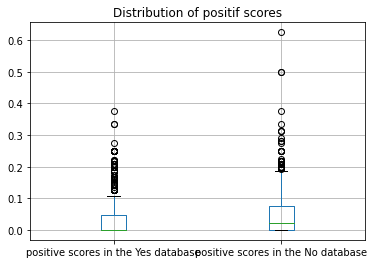

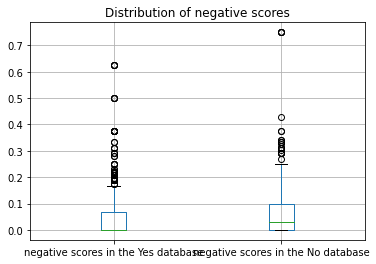

In [0]:
# Boxplot des distributions des scores 

# Positive scores  No and Yes base scores  
lis_pos_no=pd.DataFrame(list(Base_SWN_no.Scores),columns=['score_pos','score_neg','score_neutre'])['score_pos']
lis_pos_yes=pd.DataFrame(list(Base_SWN_yes.Scores),columns=['score_pos','score_neg','score_neutre'])['score_pos']

# Negative scores  No and Yes base scores   
lis_neg_no=pd.DataFrame(list(Base_SWN_no.Scores),columns=['score_pos','score_neg','score_neutre'])['score_neg']
lis_neg_yes=pd.DataFrame(list(Base_SWN_yes.Scores),columns=['score_pos','score_neg','score_neutre'])['score_neg']


Base_pos=pd.DataFrame([[x,y] for (x,y) in zip(lis_pos_yes,lis_pos_no)],columns=['positive scores in the Yes database','positive scores in the No database'])
Base_neg=pd.DataFrame([[x,y] for (x,y) in zip(lis_neg_yes,lis_neg_no)],columns=['negative scores in the Yes database','negative scores in the No database']) 

x=Base_pos.plot.box(grid='True',title='Distribution of positif scores')
x=Base_neg.plot.box(grid='True',title='Distribution of negative scores')

$\underline{Comments}$

Concerning the positive scores, the distribution of these scores is approximately the same for the Yes and No databases.

For negative scores, the distribution is different. It can be observed that tweets in the No database are more negatively scorned. For example, the 3rd quartile of negative scores is 0.10 for the No database; 0.075 for the Yes database. By observing the boxplots of these distributions, we can see that the difference is quite significant. 

The same remark can be made for positive scores.

In addition to the different arguments between the No and Yes tweets (see part II.a, II.b), the tonality informs us of the pessimistic/optimistic character of the tweets. Skeptics seem to have a more incisive tone. This is interesting in the sense that the supposed 'pessimism' of the Yes tweets (about global warming, rising temperatures...) seems to be overtaken by the 'negativity' of the No tweets (about fraud, scandals, lies). This can be explained by the fact that No tweets are often accompanied by stronger words and, at times, insults. 

To summarize the three scores associated with a tweet, we can determine whether the positive score is higher than the negative score. 

In [0]:
#A Tweet can be scored as positive if its negative score is greater than its positive score;
# and vice versa. If the two scores are equal it is classified as neutral.

def stati_scores_major(base):
    base=pd.DataFrame(list(base.Scores),columns=['score_pos','score_neg','score_neutre'])
    base['pos']=(base['score_pos']>base['score_neg'])*1
    base['neg']=(base['score_neg']>base['score_pos'])*1
    return([sum(base['pos']),sum(base['neg']),len(base)-(sum(base['neg'])+sum(base['pos']))])

# On the entire database
data=Base_SWN[Base_SWN.Scores!='no words known by SWN']
results=stati_scores_major(data)
print(' ')
print('On the entire database ({} tweets) : '.format(len(data)))
print(' ')
print('The number of tweets judged positive is {} --> {}%'.format(str(results[0]),str(round(100*results[0]/len(data),2))))
print('The number of tweets judged negative is {} --> {}%'.format(str(results[1]),str(round(100*results[1]/len(data),2))))
print('The number of tweets judged neutral is{} --> {}%'.format(str(results[2]),str(round(100*results[2]/len(data),2))))
print(' ')
print('#'*30)
print('#'*30)
print(' ')

# On the basis of the Yes  
data=Base_SWN_yes
results=stati_scores_major(data)
print(' ')
print('On a compound basis of the Yes ({} tweets) : '.format(len(data)))
print(' ')
print('The number of tweets judged positive is {} --> {}%'.format(str(results[0]),str(round(100*results[0]/len(data),2))))
print('The number of tweets judged negative is {} --> {}%'.format(str(results[1]),str(round(100*results[1]/len(data),2))))
print('The number of tweets judged neutral is {} --> {}%'.format(str(results[2]),str(round(100*results[2]/len(data),2))))
print(' ')
print('#'*30)
print('#'*30)
print(' ')

# On the basis of the No 
data=Base_SWN_no
results=stati_scores_major(data)
print(' ')
print('On a compound basis of the No ({} tweets) : '.format(len(data)))
print(' ')
print('The number of tweets judged positive is {} --> {}%'.format(str(results[0]),str(round(100*results[0]/len(data),2))))
print('The number of tweets judged negtives is {} --> {}%'.format(str(results[1]),str(round(100*results[1]/len(data),2))))
print('The number of tweets judged neutral is {} --> {}%'.format(str(results[2]),str(round(100*results[2]/len(data),2))))
print(' ')
print('#'*30)
print('#'*30)
print(' ')


 
On the entire database (5435 tweets) : 
 
The number of tweets judged positive is 1452 --> 26.72%
The number of tweets judged negative is 1837 --> 33.8%
The number of tweets judged neutral is2146 --> 39.48%
 
##############################
##############################
 
 
On a compound basis of the Yes (2779 tweets) : 
 
The number of tweets judged positive is 740 --> 26.63%
The number of tweets judged negative is 939 --> 33.79%
The number of tweets judged neutral is 1100 --> 39.58%
 
##############################
##############################
 
 
On a compound basis of the No (1014 tweets) : 
 
The number of tweets judged positive is 297 --> 29.29%
The number of tweets judged negtives is 406 --> 40.04%
The number of tweets judged neutral is 311 --> 30.67%
 
##############################
##############################
 


$\underline{Comments}$

We observe that the majority of tweets are negative in tone, whether they are Yes or No. Nevertheless, pessimism or optimism is more marked in the tweets of skeptics. For example, tweets with negative tones represent $40.04$% of the No base compared to $33.79$% for Yes tweets. The demonstrative character of the climate-skeptics can be found in the tweets of climate-skeptics.

As an example, here are some tweets judged very 'negatively' in the No' database:

In [0]:
def stati_scores_tweets(base):
    base_1=base.copy()
    base=pd.DataFrame(list(base.Scores),columns=['score_pos','score_neg','score_neutre'])
    base['Tweet']=base_1.Tweet
    return(base)

# Print of tweets
data=Base_SWN_no.reset_index()
data=stati_scores_tweets(data)
data=data.sort_values(by=['score_neg'],ascending=False).reset_index()
print(' ')
print(data.Tweet[4])
print('score négatif : {}'.format(str(data.score_neg[4])))
print(' ')
print(data.Tweet[7])
print('score négatif : {}'.format(str(data.score_neg[7])))
print(' ')

 
If Ensler & Behar represent liberal women, that's such a sad pathetic stmt. Global warming fanatics who yack about their vaginas. Pathetic!
score négatif : 0.42857142857142855
 
RT @gopevangelist: Global warming hysteria presumes 3 things: 1 it exists, 2 it is man-made, 3 it is bad. All 3 must be true. This winter may prove all 3 false
score négatif : 0.3392857142857143
 
